## 1. 데이터 불러오기


### 필수 라이브러리


In [54]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [55]:
# train_cleaned로 전처리된 파일 불러오기 (밀기, 결측치 x, 동일 값(모든 행이 같은 값을 가지는) 컬럼 제거, 중복(서로 다른 컬럼의 데이터가 같은) 컬럼 제거)

ROOT_DIR = "./data"
RANDOM_STATE = 110

# Load data
df = pd.read_csv(os.path.join(ROOT_DIR, "train_cleaned.csv"))
df

,Equipment_Dam,Model.Suffix,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,240.0,2.5,-90,100,1030,16,14.9,8.4,...,156.0,427.9,428.0,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #2,AJX75334501,1000.0,12.5,90,85,280,16,14.7,8.5,...,694.0,1324.2,1324.2,243.5,114.612,19.8,10.0,73,1,Normal
2,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,16,13.2,6.5,...,156.0,427.9,428.0,243.7,85.000,19.7,8.0,483,1,Normal
3,Dam dispenser #2,AJX75334501,1000.0,12.5,90,70,280,16,13.2,7.6,...,694.0,1324.2,1324.2,243.5,85.000,19.9,11.0,105,1,Normal
4,Dam dispenser #2,AJX75334501,1000.0,12.5,90,85,280,16,14.7,8.5,...,694.0,1324.2,1324.2,243.5,114.612,20.0,15.0,78,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,9.7,4.9,...,156.0,427.9,428.0,243.7,85.000,19.6,2.0,56,1,Normal
40502,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,9.7,4.9,...,156.0,427.9,428.0,243.7,85.000,19.3,8.0,329,1,Normal
40503,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,17.0,5.0,...,156.0,427.9,428.0,243.7,85.000,19.2,1.0,318,1,Normal
40504,Dam dispenser #2,AJX75334501,1000.0,12.5,90,70,280,10,9.7,4.9,...,694.0,1324.2,1324.2,243.5,85.000,20.1,13.0,117,1,Normal


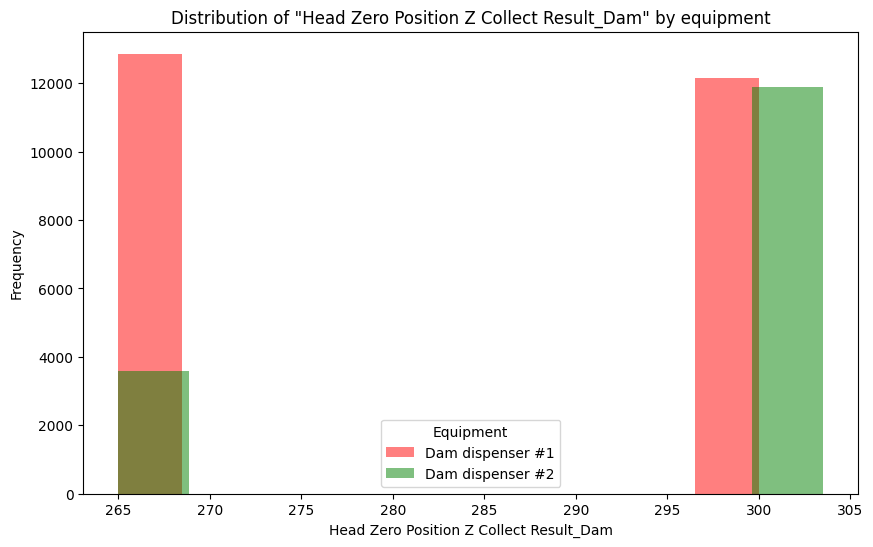

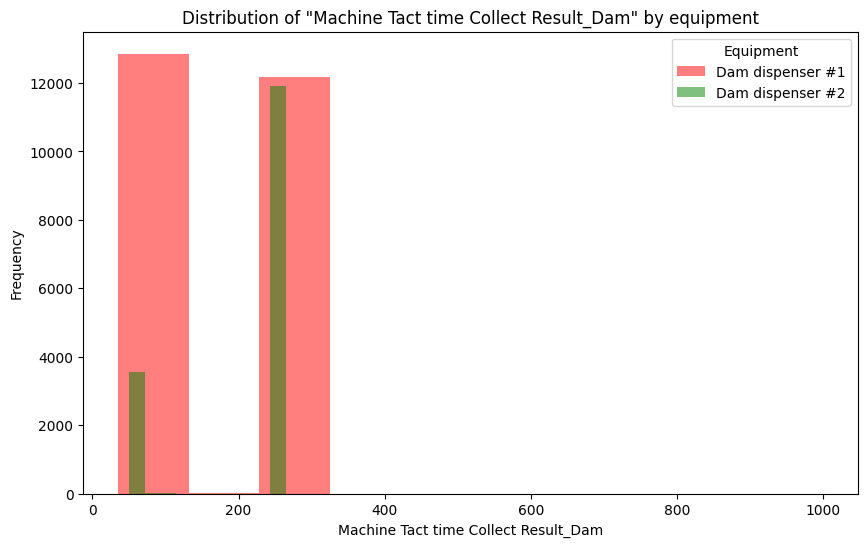

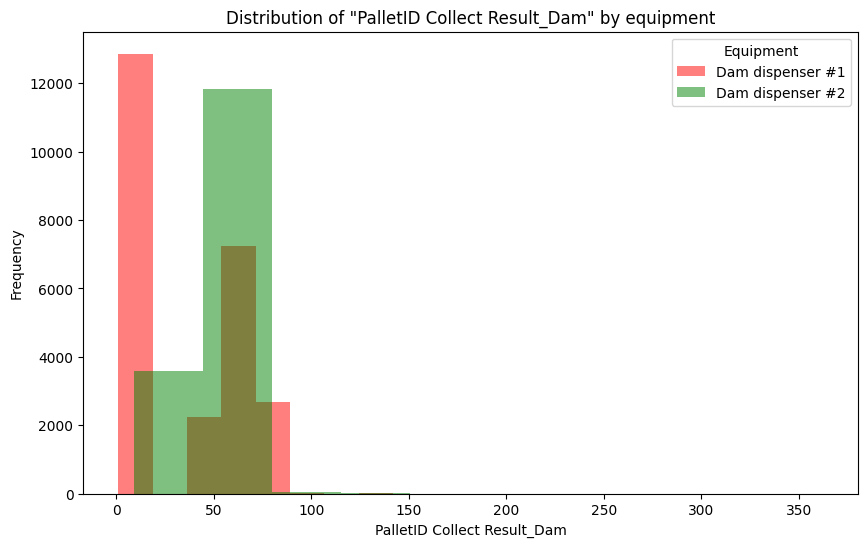

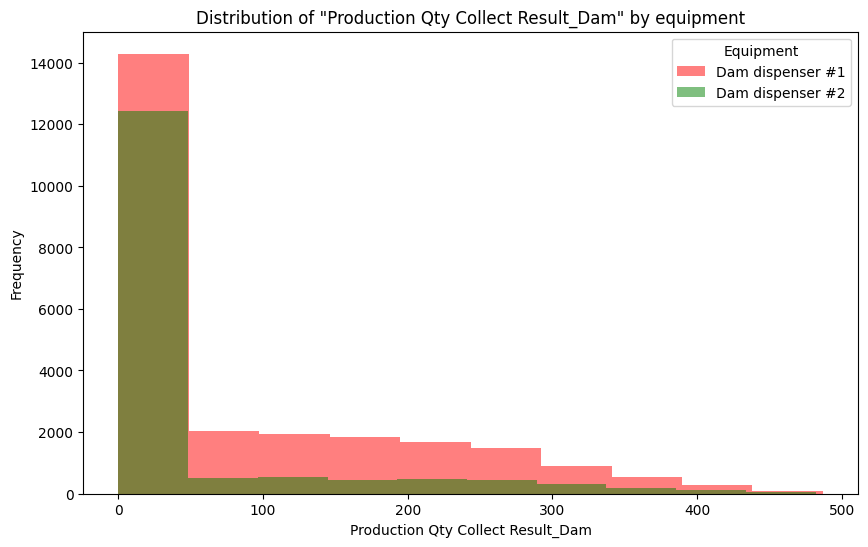

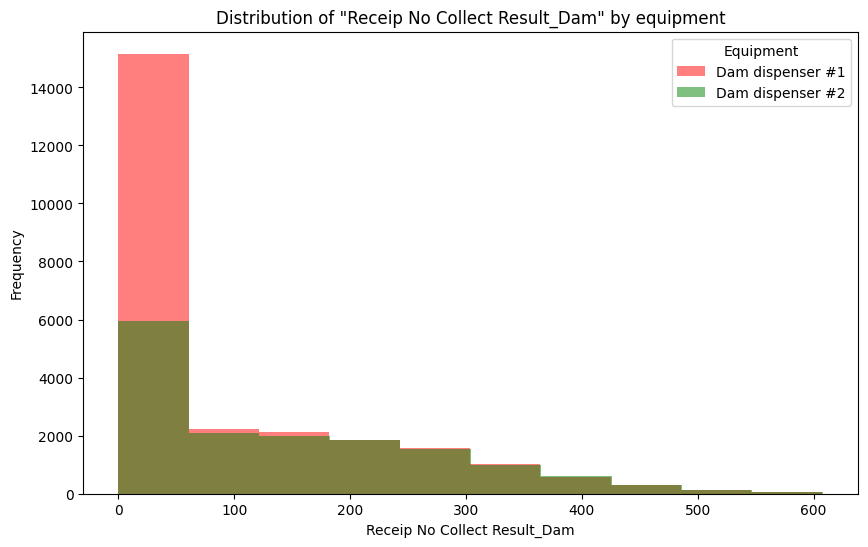

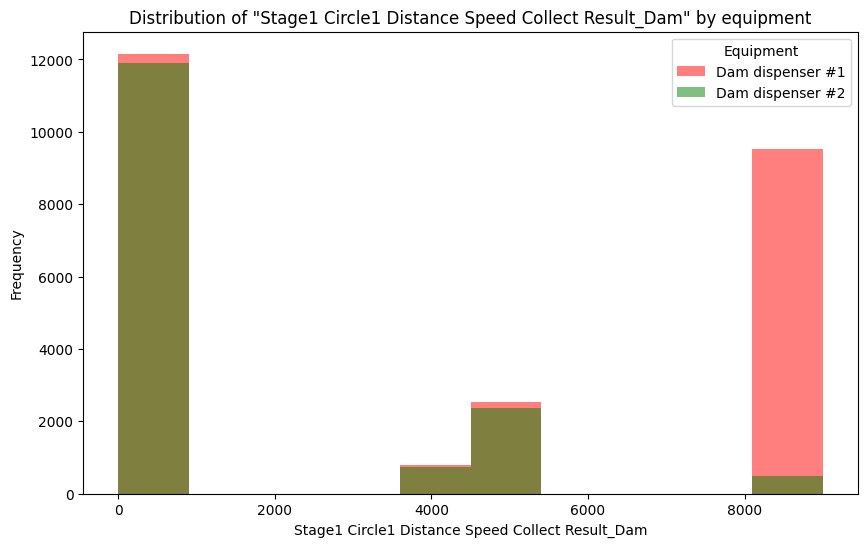

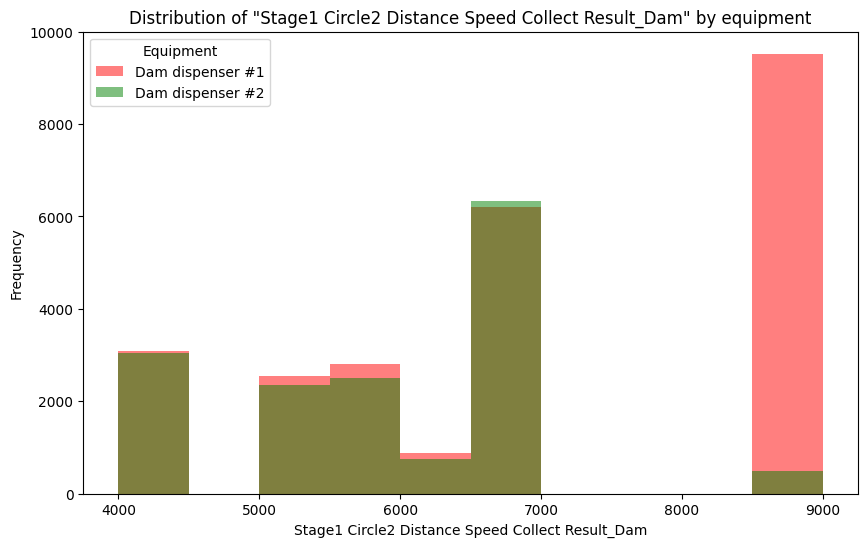

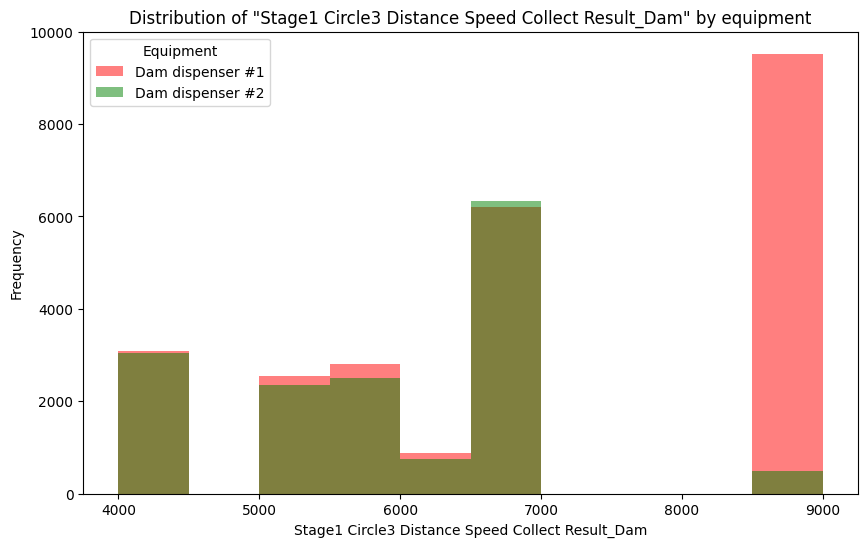

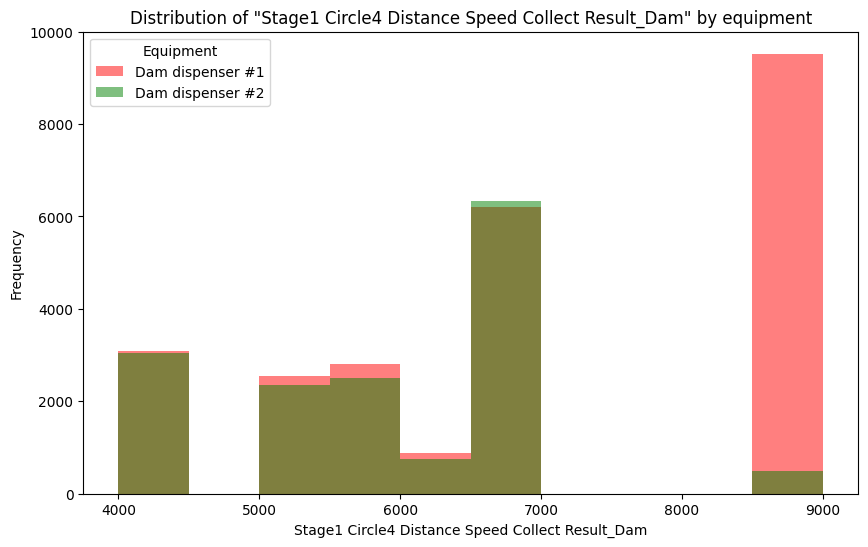

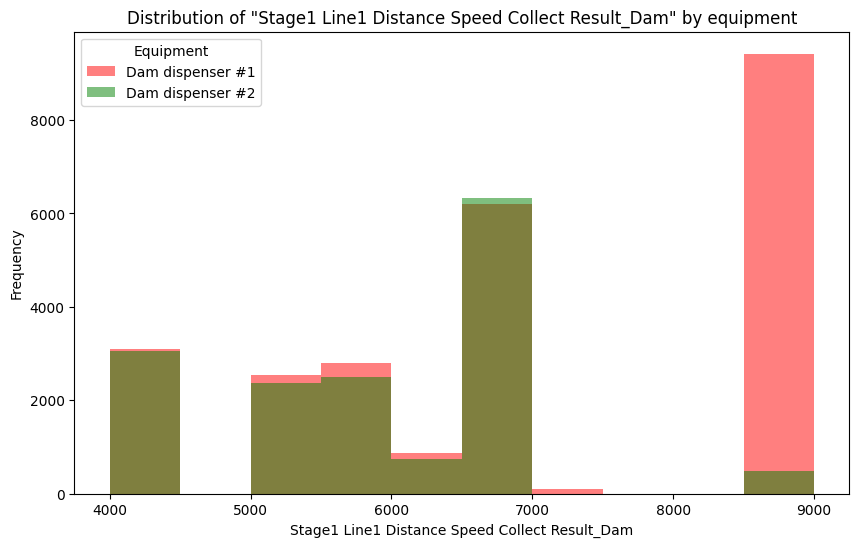

In [41]:
# 먼저 확인할 것은 Dam의 equipment에 따라 구분 됨
import pandas as pd
import matplotlib.pyplot as plt

# 색상 지정
equpment_type = df['Equipment_Dam'].unique()
colors = {}
color_list=['r','g','b']
c=0
for i in equpment_type:
    colors[i] = color_list[c]
    c+=1

# 각 장비별로 데이터를 분리하여 히스토그램 그리기
for i in df.columns[35:45]:
    plt.figure(figsize=(10, 6))
    for equipment in equpment_type:
        subset = df[df['Equipment_Dam'] == equipment]
        plt.hist(subset[i], color=colors[equipment], alpha=0.5, label=equipment)
    
    plt.title(f'Distribution of "{i}" by equipment')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.legend(title='Equipment')
    plt.show()

<Axes: >

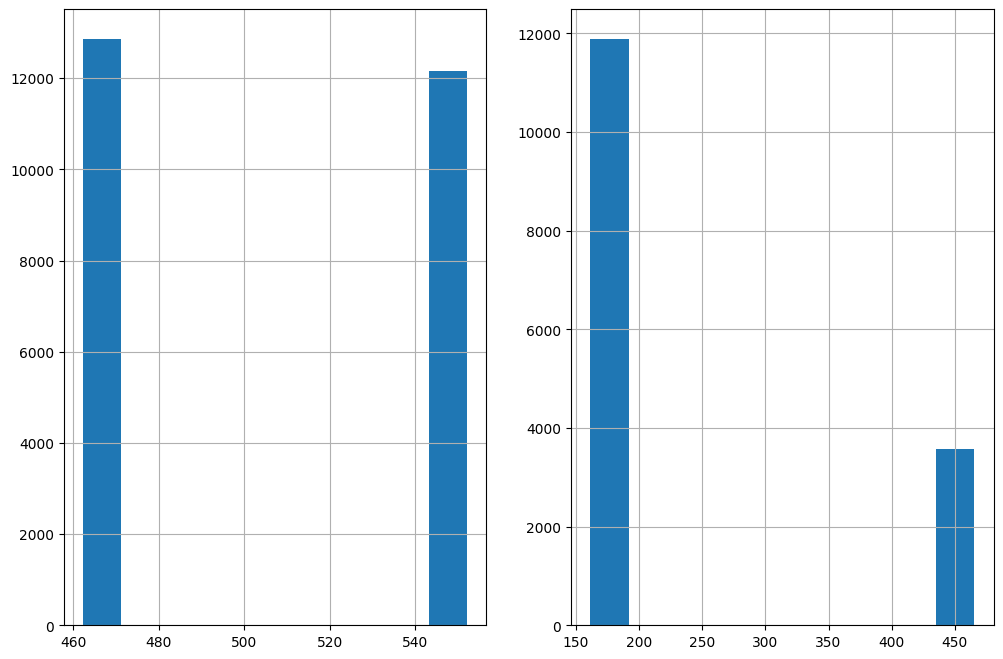

In [16]:
# 이상치 및 패턴 파악 및 컬럼 이동 판단
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
df[df['Equipment_Dam']=='Dam dispenser #1']['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'].hist()
plt.subplot(1,2,2)
df[df['Equipment_Dam']=='Dam dispenser #2']['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'].hist()

In [56]:
df

,Equipment_Dam,Model.Suffix,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,240.0,2.5,-90,100,1030,16,14.9,8.4,...,156.0,427.9,428.0,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #2,AJX75334501,1000.0,12.5,90,85,280,16,14.7,8.5,...,694.0,1324.2,1324.2,243.5,114.612,19.8,10.0,73,1,Normal
2,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,16,13.2,6.5,...,156.0,427.9,428.0,243.7,85.000,19.7,8.0,483,1,Normal
3,Dam dispenser #2,AJX75334501,1000.0,12.5,90,70,280,16,13.2,7.6,...,694.0,1324.2,1324.2,243.5,85.000,19.9,11.0,105,1,Normal
4,Dam dispenser #2,AJX75334501,1000.0,12.5,90,85,280,16,14.7,8.5,...,694.0,1324.2,1324.2,243.5,114.612,20.0,15.0,78,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,9.7,4.9,...,156.0,427.9,428.0,243.7,85.000,19.6,2.0,56,1,Normal
40502,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,9.7,4.9,...,156.0,427.9,428.0,243.7,85.000,19.3,8.0,329,1,Normal
40503,Dam dispenser #1,AJX75334501,240.0,2.5,-90,70,1030,10,17.0,5.0,...,156.0,427.9,428.0,243.7,85.000,19.2,1.0,318,1,Normal
40504,Dam dispenser #2,AJX75334501,1000.0,12.5,90,70,280,10,9.7,4.9,...,694.0,1324.2,1324.2,243.5,85.000,20.1,13.0,117,1,Normal


In [58]:
df.filter(like='PalletID')

,PalletID Collect Result_Dam,PalletID Collect Result_Fill1,PalletID Collect Result_Fill2
0,7.0,7.0,7.0
1,10.0,10.0,10.0
2,8.0,8.0,8.0
3,11.0,11.0,11.0
4,15.0,15.0,15.0
...,...,...,...
40501,2.0,2.0,2.0
40502,8.0,8.0,8.0
40503,1.0,1.0,1.0
40504,13.0,13.0,13.0
